## Локальный и глобальный поиск

Решите задачу коммивояжера на основе файла данных `hw9_data/tsp.csv`: найти минимальный НЕЦИКЛИЧЕСКИЙ путь (начинается и заканчивается в разных точках), соединяющий N точек. Файл содержит координаты каждого из городов на плоскости (1й столбец - номер города, 2й и 3й - координаты). Используйте L1 расстояние для расчетов и визуализации.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import copy

In [2]:
data = np.genfromtxt('hw9_data/tsp.csv', delimiter=',')
coords = data[:, [1,2]]
N = len(coords)

In [3]:
def dist(p, q):
    return np.sum(np.abs(p-q))

In [4]:
def cost(seq):
    res = 0
    for i in range(N - 1):
        res += dist(coords[seq[i]], coords[seq[i+1]])
    return res

In [5]:
def plot(seq, cost, name):
    plt.plot(coords[seq][:, 0], coords[seq][:, 1], 'o-')
    plt.axis('off')
    plt.title(f'{name}, cost={cost}')

### Задание 1 (1 балл) 

Реализуйте Монте-Карло поиск.

In [41]:
iters = 10000
res = []
for _ in range(iters):
    seq = np.random.permutation(N)
    c = cost(seq)
    res.append((c, seq))
MC_min_cost, MC_min_seq = min(res)

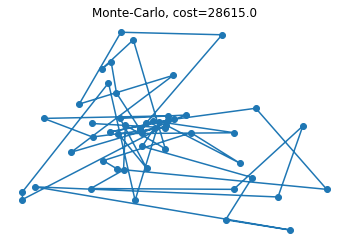

In [42]:
plot(MC_min_seq, MC_min_cost, 'Monte-Carlo')

### Задание 2 (1 балл) 

Реализуйте поиск случайным блужданием.

In [62]:
iters = 100
res = []
for _ in range(iters):
    Q = list(range(N))
    RW_seq = [random.choice(Q)]
    Q.remove(RW_seq[0])
    while Q:
        weights = [1/dist(coords[RW_seq[-1]], coords[q]) for q in Q]
        i = random.choices(Q, weights)[0]
        RW_seq.append(i)
        Q.remove(i)
    RW_cost = cost(RW_seq)
    res.append((RW_cost, RW_seq))
RW_min_cost, RW_min_seq = min(res)

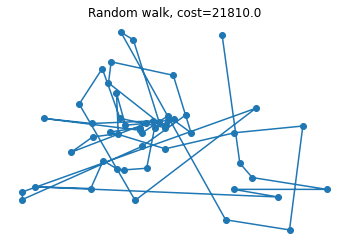

In [63]:
plot(RW_min_seq, RW_min_cost, 'Random walk')

### Задание 3 (2 балла) 

Реализуйте Hill Climb.

In [6]:
def getNeighbours(seq):
    for i in range(N):
        for j in range(i+1, N):
            neighbour = copy(seq)
            neighbour[i] = seq[j]
            neighbour[j] = seq[i]
            yield neighbour

In [7]:
res = []
for _ in range(10):
    seq = np.random.permutation(N)
    c = cost(seq)
    for _ in range(1000):
        neighbours = [(cost(nei), nei) for nei in getNeighbours(seq)]
        nei_cost, nei = min(neighbours, key=lambda x: x[0])
        if nei_cost >= c:
            break
        c = nei_cost
        seq = copy(nei)
    res.append((c, copy(seq)))
HC_min_cost, HC_min_seq = min(res)

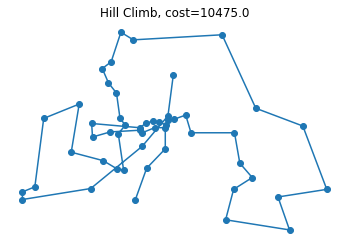

In [8]:
plot(HC_min_seq, HC_min_cost, 'Hill Climb')

### Задание 4 (3 балла) 


Реализуйте отжиг (simulated annealing). Температурный режим отжига выберите самостоятельно.

In [140]:
seq = np.random.permutation(N)
c = cost(seq)
best_seq = copy(seq)
best_cost = c
T = 1000
for i in range(10000):
    a, b = sorted(random.sample(range(N), 2))
    new_seq = list(seq[:a]) + list(reversed(seq[a:b])) + list(seq[b:])
    new_cost = cost(new_seq)
    t = T/float(i + 1)
    diff = new_cost - c
    criterion = np.exp(-diff/t)
    if new_cost < c or random.random() < criterion:
        seq = copy(new_seq)
        c = new_cost
        
        if c < best_cost:
            best_seq = copy(seq)
            best_cost = c

<ipython-input-140-3e90b43c5867>:12: RuntimeWarning: overflow encountered in exp
  criterion = np.exp(-diff/t)


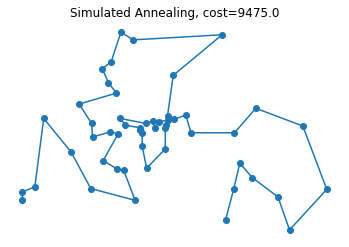

In [141]:
plot(best_seq, best_cost, 'Simulated Annealing')

### Задание 5 (3 балла) 

Реализуйте генетический алгоритм.

In [98]:
def mutate(seq, prob):
    # Мутация моделируется перестановкой двух смежных городов с вероятностью prob
    new_seq = copy(seq)
    if random.random() < prob:
        i = random.randint(0, N-2)
        new_seq[i] = seq[i + 1]
        new_seq[i + 1] = seq[i]
    return new_seq

def crossover(A, B):
    # Кроссовер моделируется случайным выбором двух точек, между которыми вырезаются 
    # и обмениваются части решений A и B. Соответствие между городами в этих отрезках используются как маппинг,
    # чтобы пофиксить участки решение слева и справа от средней области
    
    i, j = sorted(random.sample(range(N), 2))
    left_A, mid_A, right_A = list(A[:i]), list(A[i:j]), list(A[j:])
    left_B, mid_B, right_B = list(B[:i]), list(B[i:j]), list(B[j:])
    map_a_b = {a: b for a, b in zip(mid_A, mid_B)}
    map_b_a = {b: a for a, b in zip(mid_A, mid_B)}

    fixed_left_A = []
    for a in left_A:
        while a in mid_B:
            a = map_b_a[a]
        fixed_left_A.append(a)
    fixed_right_A = []    
    for a in right_A:
        while a in mid_B:
            a = map_b_a[a]
        fixed_right_A.append(a)
    fixed_left_B = []
    for b in left_B:
        while b in mid_A:
            b = map_a_b[b]
        fixed_left_B.append(b)
    fixed_right_B = []    
    for b in right_B:
        while b in mid_A:
            b = map_a_b[b]
        fixed_right_B.append(b)

    new_A = fixed_left_A + mid_B + fixed_right_A
    new_B = fixed_left_B + mid_A + fixed_right_B
    
    return new_A, new_B

In [159]:
k = 1000
mut_prob = 0.5
population = []
for _ in range(k):
    seq = np.random.permutation(N) 
    population.append((cost(seq), seq))
    
generations = 500
mean_cost = []

for gen in range(generations):
    mean_cost.append(np.mean([p[0] for p in population]))
    fitness = [1/p[0] for p in population]
    probs = fitness / sum(fitness)
    # Случайная половина популяции оставляет потомство с вероятностями ~ приспособленности
    parents = np.random.choice(range(k), size=k//2, replace=False, p=probs)
    for i in range(0, k//2, 2):
        new_A, new_B = crossover(population[parents[i]][1], population[parents[i+1]][1])
        new_A = mutate(new_A, mut_prob)
        new_B = mutate(new_B, mut_prob)
        population.append((cost(new_A), new_A))
        population.append((cost(new_B), new_B))
    # Лучшие k переходят в следующую популяцию 
    population = sorted(population, key=lambda x: x[0])[:k]
GA_best_cost, GA_best_seq = min(population, key=lambda x: x[0])

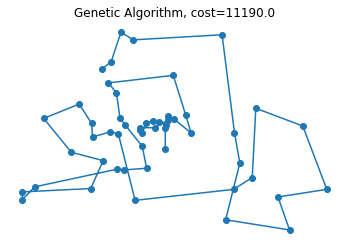

In [160]:
plot(GA_best_seq, GA_best_cost, 'Genetic Algorithm')

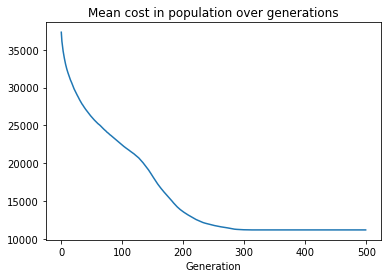

In [161]:
plt.plot(mean_cost)
plt.xlabel('Generation')
plt.title('Mean cost in population over generations')
plt.show()